<a href="https://colab.research.google.com/github/naufalihsan/tesseract/blob/master/Text_Predicting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import files

uploaded = files.upload()

Saving train.csv to train.csv


## Read Dataset

In [0]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,Unnamed: 0,entity,category
0,0,Mutia Maryati,name
1,1,Padmi Susanti M.Farm,name
2,2,Karen Ayu Nuraini,name
3,3,Bagus Pangestu S.E.,name
4,4,Violet Halimah,name


## Text Cleaning

- remove punctuation
- make lowercase

In [0]:
def primary_name(names):
  names = names.replace('.',' ').split(" ")
  thres = min(3,len(names))
  if len(names[thres-1]) == 1:
    thres -= 1
  return " ".join(names[:thres]).lower()

In [71]:
train = df.copy()
primary_name = train.query('category == "name"')['entity'].apply(lambda x : primary_name(x))

0              mutia maryati
1              padmi susanti
2          karen ayu nuraini
3             bagus pangestu
4             violet halimah
               ...          
484     ika unjani puspasari
485    martana ihsan saptono
486      restu ellis uyainah
487    irsad samsul marpaung
488               dewi utami
Name: entity, Length: 489, dtype: object

In [0]:
frame = { 'entity': primary_name, 'category': 'name' } 
result = pd.DataFrame(frame) 

In [0]:
def primary_address(address):
  address = address.strip().replace('.',' ').replace(',',' ').split(" ")
  if address[0] == 'Jr' or address[0] == 'Jln':
    address[0] = 'jl'
  elif address[0] == 'Dk':
    address[0] = 'dusun'
  elif address[0] == 'Ds':
    address[0] = 'desa'
  elif address[0] == 'Kpg' or address[0] == 'Ki':
    address[0] = 'kampung'
  return " ".join(address)

In [106]:
primary_address = train.query('category == "address"')['entity'].apply(lambda y: primary_address(y))
display(primary_address)

978     jl  Asia Afrika No  721  Lhokseumawe 13933  Jambi
979     dusun  Ketandan No  978  Kotamobagu 49016  KalBar
980     Gg  Pelajar Pejuang 45 No  628  Magelang 97885...
981      desa  Dr  Junjunan No  814  Depok 88910  Lampung
982          desa  Nanas No  645  Mojokerto 32506  SumSel
                              ...                        
1462                jl  Otto No  757  Ambon 93035  SumBar
1463    desa  Basmol Raya No  634  Sungai Penuh 36520 ...
1464          Gg  Basket No  66  Pekalongan 94958  KalSel
1465         dusun  Lada No  280  Sungai Penuh 10640  NTB
1466    desa  K H  Wahid Hasyim (Kopo) No  472  Jambi ...
Name: entity, Length: 489, dtype: object

In [0]:
frame = { 'entity': primary_address, 'category': 'address' } 
result2 = pd.DataFrame(frame)

In [0]:
result3 = train.query('category == "ttl" or category == "card"')

In [0]:
result = result.append(result2,sort=False, ignore_index=True)
result = result.append(result3,sort=False, ignore_index=True)

In [0]:
from google.colab import files

result.to_csv('new_train.csv', index = False, header=True)
files.download('new_train.csv')

## Building model

- build model to classify entity to its category

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(result['entity'])

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)

In [0]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [152]:
from sklearn.preprocessing import LabelEncoder

# creating mapping from unique label texts to unique integers
# note this can be re-used to encode and decode the labels after as well

encoder = LabelEncoder()
target = encoder.fit_transform(result['category'])

print(target)

[2 2 2 ... 1 1 1]


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, target, test_size = 0.15, random_state = 21)

In [154]:
from sklearn.ensemble import GradientBoostingClassifier

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(
        n_estimators = 100, learning_rate = learning_rate,
        max_depth = 2, random_state = 21)
    gb.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.738
Accuracy score (validation): 0.607
Learning rate:  0.1
Accuracy score (training): 0.766
Accuracy score (validation): 0.613
Learning rate:  0.25
Accuracy score (training): 0.847
Accuracy score (validation): 0.654
Learning rate:  0.5
Accuracy score (training): 0.873
Accuracy score (validation): 0.681
Learning rate:  0.75
Accuracy score (training): 0.878
Accuracy score (validation): 0.677
Learning rate:  1
Accuracy score (training): 0.879
Accuracy score (validation): 0.687


In [0]:
from sklearn.naive_bayes import MultinomialNB


clf = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=1,
    max_depth=2,
    random_state=21).fit(X_train, y_train)

In [156]:
datas = ['Naufal Ihsan Pratama',
         'Jakarta  21 01 1989',
         'Jl Senayan GG BB No 25',
         '3217061804870007']
X_new_counts = count_vect.transform(datas)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

cheatsheet = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
predicted = clf.predict(X_new_tfidf)

print('Evaluation Test')

for doc, category in zip(datas, predicted):
    print('Entity : {} => Predict type : {}'.format(doc, cheatsheet[category]))

Evaluation Test
Entity : Naufal Ihsan Pratama => Predict type : name
Entity : Jakarta  21 01 1989 => Predict type : ttl
Entity : Jl Senayan GG BB No 25 => Predict type : address
Entity : 3217061804870007 => Predict type : card


Text(0.5, 1.0, 'Confusion Matrix')

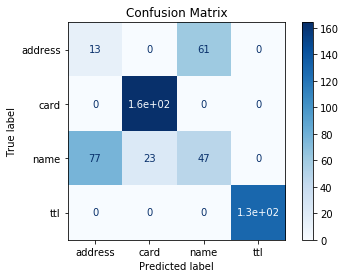

In [157]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib as plt

disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels= encoder.classes_,
                                 cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix')